In [7]:


from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b



import tensorflow as tf
tf.compat.v1.disable_eager_execution()

if tf.__version__.startswith('2'):
  tf.compat.v1.disable_eager_execution()


def VGG16_AvgPool(shape):
  # we want to account for features across the entire image
  # so get rid of the maxpool which throws away information
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

  # new_model = Sequential()
  # for layer in vgg.layers:
  #   if layer.__class__ == MaxPooling2D:
  #     # replace it with average pooling
  #     new_model.add(AveragePooling2D())
  #   else:
  #     new_model.add(layer)

  i = vgg.input
  x = i
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      # replace it with average pooling
      x = AveragePooling2D()(x)
    else:
      x = layer(x)

  return Model(i, x)

def VGG16_AvgPool_CutOff(shape, num_convs):
  # there are 13 convolutions in total
  # we can pick any of them as the "output"
  # of our content model

  if num_convs < 1 or num_convs > 13:
    print("num_convs must be in the range [1, 13]")
    return None

  model = VGG16_AvgPool(shape)
  # new_model = Sequential()
  # n = 0
  # for layer in model.layers:
  #   if layer.__class__ == Conv2D:
  #     n += 1
  #   new_model.add(layer)
  #   if n >= num_convs:
  #     break

  n = 0
  output = None
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
    if n >= num_convs:
      output = layer.output
      break

  return Model(model.input, output)


def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img


def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x


if __name__ == '__main__':

  # open an image
  # feel free to try your own
  # path = '../large_files/caltech101/101_ObjectCategories/elephant/image_0002.jpg'
  path = '/content/145.jpg'
  img = image.load_img(path)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  # we'll use this throughout the rest of the script
  batch_shape = x.shape
  shape = x.shape[1:]

  # see the image
  # plt.imshow(img)
  # plt.show()


  # make a content model
  # try different cutoffs to see the images that result
  content_model = VGG16_AvgPool_CutOff(shape, 11)

  # make the target
  target = K.variable(content_model.predict(x))


  # try to match the image

  # define our loss in keras
  loss = K.mean(K.square(target - content_model.output))

  # gradients which are needed by the optimizer
  grads = K.gradients(loss, content_model.input)

  # just like theano.function
  get_loss_and_grads = K.function(
    inputs=[content_model.input],
    outputs=[loss] + grads
  )


  def get_loss_and_grads_wrapper(x_vec):
    # scipy's minimizer allows us to pass back
    # function value f(x) and its gradient f'(x)
    # simultaneously, rather than using the fprime arg
    #
    # we cannot use get_loss_and_grads() directly
    # input to minimizer func must be a 1-D array
    # input to get_loss_and_grads must be [batch_of_images]
    #
    # gradient must also be a 1-D array
    # and both loss and gradient must be np.float64
    # will get an error otherwise

    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)



  from datetime import datetime
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(10):
    x, l, _ = fmin_l_bfgs_b(
      func=get_loss_and_grads_wrapper,
      x0=x,
      # bounds=[[-127, 127]]*len(x.flatten()),
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    # print("min:", x.min(), "max:", x.max())
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)


  plt.imshow(scale_img(final_img[0]))
  plt.show()



Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 690, 690, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 690, 690, 3), dtype=float32)
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


iter=0, loss=1692.220947265625


KeyboardInterrupt: ignored

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 177, 284, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 177, 284, 3), dtype=float32)


iter=0, loss=7730.33203125
iter=1, loss=741.4644775390625
iter=2, loss=318.617431640625
iter=3, loss=191.7003631591797
iter=4, loss=139.52342224121094
iter=5, loss=106.55176544189453
iter=6, loss=85.83269500732422
iter=7, loss=66.22724914550781
iter=8, loss=52.98661422729492
iter=9, loss=44.65301513671875
duration: 0:05:10.458830


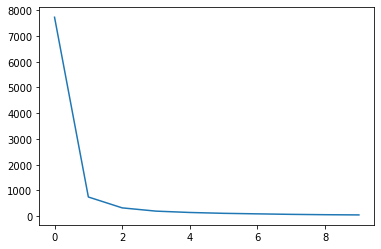

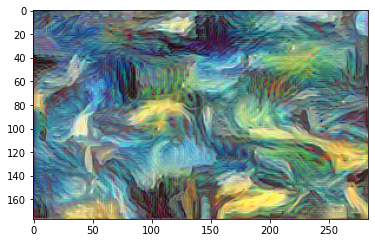

In [6]:
# Note: you may need to update your version of future
# sudo pip install -U future

# In this script, we will focus on generating an image
# with the same style as the input image.
# But NOT the same content.
# It should capture only the essence of the style.

from keras.models import Model, Sequential
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import VGG16

#from tstyler1 import VGG16_AvgPool, unpreprocess, scale_img
# from skimage.transform import resize
from scipy.optimize import fmin_l_bfgs_b
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
def VGG16_AvgPool(shape):
  # we want to account for features across the entire image
  # so get rid of the maxpool which throws away information
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

  # new_model = Sequential()
  # for layer in vgg.layers:
  #   if layer.__class__ == MaxPooling2D:
  #     # replace it with average pooling
  #     new_model.add(AveragePooling2D())
  #   else:
  #     new_model.add(layer)

  i = vgg.input
  x = i
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      # replace it with average pooling
      x = AveragePooling2D()(x)
    else:
      x = layer(x)

  return Model(i, x)

def VGG16_AvgPool_CutOff(shape, num_convs):
  # there are 13 convolutions in total
  # we can pick any of them as the "output"
  # of our content model

  if num_convs < 1 or num_convs > 13:
    print("num_convs must be in the range [1, 13]")
    return None

  model = VGG16_AvgPool(shape)
  # new_model = Sequential()
  # n = 0
  # for layer in model.layers:
  #   if layer.__class__ == Conv2D:
  #     n += 1
  #   new_model.add(layer)
  #   if n >= num_convs:
  #     break

  n = 0
  output = None
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
    if n >= num_convs:
      output = layer.output
      break

  return Model(model.input, output)


def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img


def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x



def gram_matrix(img):
  # input is (H, W, C) (C = # feature maps)
  # we first need to convert it to (C, H*W)
  X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  
  # now, calculate the gram matrix
  # gram = XX^T / N
  # the constant is not important since we'll be weighting these
  G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
  return G


def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))


# let's generalize this and put it into a function
def minimize(fn, epochs, batch_shape):
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
      func=fn,
      x0=x,
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)
  return final_img[0]


if __name__ == '__main__':
  # try these, or pick your own!
  path = '/content/148.jpg'
  # path = 'styles/flowercarrier.jpg'
  # path = 'styles/monalisa.jpg'
  # path = 'styles/lesdemoisellesdavignon.jpg'


  # load the data
  img = image.load_img(path)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)

  # look at the image
  # plt.imshow(x)
  # plt.show()

  # make it (1, H, W, C)
  x = np.expand_dims(x, axis=0)

  # preprocess into VGG expected format
  x = preprocess_input(x)

  # we'll use this throughout the rest of the script
  batch_shape = x.shape
  shape = x.shape[1:]

  # let's take the first convolution at each block of convolutions
  # to be our target outputs
  # remember that you can print out the model summary if you want
  vgg = VGG16_AvgPool(shape)

  # Note: need to select output at index 1, since outputs at
  # index 0 correspond to the original vgg with maxpool
  symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers \
    if layer.name.endswith('conv1')
  ]

  # pick the earlier layers for
  # a more "localized" representation
  # this is opposed to the content model
  # where the later layers represent a more "global" structure
  # symbolic_conv_outputs = symbolic_conv_outputs[:2]

  # make a big model that outputs multiple layers' outputs
  multi_output_model = Model(vgg.input, symbolic_conv_outputs)

  # calculate the targets that are output at each layer
  style_layers_outputs = [K.variable(y) for y in multi_output_model.predict(x)]

  # calculate the total style loss
  loss = 0
  for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs):
    # gram_matrix() expects a (H, W, C) as input
    loss += style_loss(symbolic[0], actual[0])

  grads = K.gradients(loss, multi_output_model.input)

  # just like theano.function
  get_loss_and_grads = K.function(
    inputs=[multi_output_model.input],
    outputs=[loss] + grads
  )


  def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)


  final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
  plt.imshow(scale_img(final_img))
  plt.show()


In [ ]:
from datetime import datetime
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from skimage.transform import resize


import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from scipy.optimize import fmin_l_bfgs_b

def gram_matrix(img):
  # input is (H, W, C) (C = # feature maps)
  # we first need to convert it to (C, H*W)
  X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  
  # now, calculate the gram matrix
  # gram = XX^T / N
  # the constant is not important since we'll be weighting these
  G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
  return G


def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))


# let's generalize this and put it into a function
def minimize(fn, epochs, batch_shape):
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
      func=fn,
      x0=x,
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)
  return final_img[0]



def VGG16_AvgPool(shape):
  # we want to account for features across the entire image
  # so get rid of the maxpool which throws away information
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

  # new_model = Sequential()
  # for layer in vgg.layers:
  #   if layer.__class__ == MaxPooling2D:
  #     # replace it with average pooling
  #     new_model.add(AveragePooling2D())
  #   else:
  #     new_model.add(layer)

  i = vgg.input
  x = i
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      # replace it with average pooling
      x = AveragePooling2D()(x)
    else:
      x = layer(x)

  return Model(i, x)

def VGG16_AvgPool_CutOff(shape, num_convs):
  # there are 13 convolutions in total
  # we can pick any of them as the "output"
  # of our content model

  if num_convs < 1 or num_convs > 13:
    print("num_convs must be in the range [1, 13]")
    return None

  model = VGG16_AvgPool(shape)
  # new_model = Sequential()
  # n = 0
  # for layer in model.layers:
  #   if layer.__class__ == Conv2D:
  #     n += 1
  #   new_model.add(layer)
  #   if n >= num_convs:
  #     break

  n = 0
  output = None
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
    if n >= num_convs:
      output = layer.output
      break

  return Model(model.input, output)


def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img


def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x


# load the content image
def load_img_and_preprocess(path, shape=None):
  img = image.load_img(path, target_size=shape)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return x



content_img = load_img_and_preprocess(
  # '../large_files/caltech101/101_ObjectCategories/elephant/image_0002.jpg',
  # 'batman.jpg',
  '/content/145.jpg',
  # (225, 300),
)

# resize the style image
# since we don't care too much about warping it
h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess(
  # 'styles/starrynight.jpg',
  # 'styles/flowercarrier.jpg',
  # 'styles/monalisa.jpg',
  '/content/148.jpg',
  (h, w)
)


# we'll use this throughout the rest of the script
batch_shape = content_img.shape
shape = content_img.shape[1:]


# we want to make only 1 VGG here
# as you'll see later, the final model needs
# to have a common input
vgg = VGG16_AvgPool(shape)


# create the content model
# we only want 1 output
# remember you can call vgg.summary() to see a list of layers
# 1,2,4,5,7-9,11-13,15-17
content_model = Model(vgg.input, vgg.layers[13].get_output_at(0))
content_target = K.variable(content_model.predict(content_img))


# create the style model
# we want multiple outputs
# we will take the same approach as in style_transfer2.py
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

# make a big model that outputs multiple layers' outputs
style_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

# we will assume the weight of the content loss is 1
# and only weight the style losses
style_weights = [0.2,0.4,0.3,0.5,0.2]



# create the total loss which is the sum of content + style loss
loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
  loss += w * style_loss(symbolic[0], actual[0])


# once again, create the gradients and loss + grads function
# note: it doesn't matter which model's input you use
# they are both pointing to the same keras Input layer in memory
grads = K.gradients(loss, vgg.input)

# just like theano.function
get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)


def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)


final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()



Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 690, 690, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 690, 690, 3), dtype=float32)
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 690, 690, 3), dtype=float32)


iter=0, loss=10894.8818359375
iter=1, loss=3994.548095703125
iter=2, loss=2218.965087890625
iter=3, loss=1676.7459716796875
iter=4, loss=1399.0472412109375
